# Squeezed-hierarchy negativity

In [1]:
from functools import partial

from scipy.linalg import expm
from matplotlib.ticker import MaxNLocator

from sparse import COO

import pysme.integrate as integ
import pysme.hierarchy as hier
import pysme.sparse_system_builder as ssb
import qinfo as qi
from qinfo.qubits import sigx, sigy, sigz, sigp, sigm, Id, zero
from qinfo import supops

In [2]:
plt.style.use('paper.mplstyle')

In [3]:
def integrator_to_lind_proc_tensor(integrator, t=0):
    if isinstance(integrator.basis, ssb.SparseBasis):
        op_basis = qi.OperatorBasis(integrator.basis.basis)
    else:
        op_basis = qi.OperatorBasis(COO.from_numpy(integrator.basis))
    lind_proc_mat = integrator.jac(t, rho_vec=None)
    lind_process = lambda rho: supops.act_proc_mat(rho, lind_proc_mat, op_basis).todense()
    lind_proc_tensor = supops.process_to_proc_tensor(lind_process, op_basis.vec_dim)
    return lind_proc_tensor

In [4]:
def xi_gau(t, Omega, ta):
    return np.power(Omega**2/(2*np.pi), 1/4) * np.exp(-Omega**2*(t - ta)**2/4)

In [5]:
def process_default_kwargs(kwargs, default_kwargs):
    """Update a default kwarg dict with user-supplied values

    """
    if kwargs is None:
        kwargs = {}
    for kwarg, value in kwargs.items():
        default_kwargs[kwarg] = value

def bar_plot(yvals, xvals=None, ax=None, subplots_kwargs=None, bar_kwargs=None):
    '''Plot an array of y values as bars wrt optional x values.

    '''
    default_subplots_kwargs = {}
    process_default_kwargs(subplots_kwargs, default_subplots_kwargs)
    default_bar_kwargs = {}
    process_default_kwargs(bar_kwargs, default_bar_kwargs)
    force_int_xticks = False
    if xvals is None:
        xvals = np.arange(len(yvals))
        force_int_xticks = True
    return_figax = False
    if ax is None:
        fig, ax = plt.subplots(**default_subplots_kwargs)
        return_figax = True
    ax.bar(xvals, yvals, **default_bar_kwargs)
    if force_int_xticks:
        # If using integer xvals, only put ticks at integer values.
        # Adapted from <https://stackoverflow.com/a/34880501/1236650>
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    return (fig, ax) if return_figax else None

Let's exponentiate the Lindbladian for some finite time, and see if that map restricted to the valid input space is a completely positive map.

In [7]:
n_max = 9

In [8]:
factory = hier.HierarchyIntegratorFactory(2, n_max)

/Users/azaghal/anaconda3/lib/python3.7/site-packages/sparse/_coo/common.py:1218: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.numpy_support', please update to use 'numba.np.numpy_support' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  locals={'data_curr': numba.numpy_support.from_dtype(dtr)})


In [9]:
op_basis = qi.OperatorBasis(factory.sparse_basis.basis.todense())

In [10]:
def xi_rect(t, ta, tb):
    amp = np.sqrt(tb - ta)
    return np.where(t < ta, 0, np.where(t <= tb, amp, 0))

In [11]:
xi_fn = partial(xi_rect, ta=0, tb=1)

In [12]:
squeezed_hier_integrator = factory.make_uncond_integrator(xi_fn, Id, sigm, zero, np.log(2), 0)

In [13]:
squeezed_hier_lind_proc_mat = squeezed_hier_integrator.jac(0, rho_vec=None)

In [14]:
squeezed_hier_finite_proc_mat = expm(squeezed_hier_lind_proc_mat)

In [15]:
squeezed_hier_finite_process = lambda rho: supops.act_proc_mat(
                                                rho,
                                                squeezed_hier_finite_proc_mat,
                                                op_basis)

In [16]:
squeezed_hier_finite_proc_tensor = supops.process_to_proc_tensor(
                                            squeezed_hier_finite_process, op_basis.vec_dim)

In [17]:
qubit_Id_proc_tensor = supops.get_identity_proc_tensor(2)
init_hier_proc_tensor = supops.get_initialize_proc_tensor(np.eye(n_max + 1, dtype=complex))

Now I'm about to do something that assumes a particular order in the `kron` that makes up the hierarchy.
Would be nice if this was transparent, and I wouldn't have to look back at the code to verify.

The krons have the system first, and the hierarchy second.

In [18]:
init_system_hier_proc_tensor = supops.tensor_proc_tensors(qubit_Id_proc_tensor,
                                                          init_hier_proc_tensor)

In [19]:
squeezed_hier_finite_proc_tensor.shape

In [20]:
init_system_hier_proc_tensor.shape

In [21]:
squeezed_sys_to_hier_proc_tensor = supops.proc_tensor_compose(
                                            squeezed_hier_finite_proc_tensor,
                                            init_system_hier_proc_tensor)

In [22]:
squeezed_sys_to_hier_proc_tensor.shape

In [23]:
squeezed_sys_to_hier_choi_mat = supops.proc_tensor_to_choi_mat(
                                                squeezed_sys_to_hier_proc_tensor)

In [34]:
squeezed_sys_to_hier_choi_mat.shape

In [24]:
squeezed_sys_to_hier_eigvals = np.linalg.eigvalsh(squeezed_sys_to_hier_choi_mat)
squeezed_sys_to_hier_positive_eigval_idxs = np.where(squeezed_sys_to_hier_eigvals > 0)
squeezed_sys_to_hier_negative_eigval_idxs = np.where(squeezed_sys_to_hier_eigvals < 0)

In [25]:
fock_hier_integrator = factory.make_uncond_integrator(xi_fn, Id, sigm, zero, np.log(1), 0)

In [26]:
fock_hier_lind_proc_mat = fock_hier_integrator.jac(0, rho_vec=None)

In [27]:
fock_hier_finite_proc_mat = expm(fock_hier_lind_proc_mat)

In [28]:
fock_hier_finite_process = lambda rho: supops.act_proc_mat(
                                                rho,
                                                fock_hier_finite_proc_mat,
                                                op_basis)

In [29]:
fock_hier_finite_proc_tensor = supops.process_to_proc_tensor(
                                            fock_hier_finite_process, op_basis.vec_dim)

In [30]:
fock_sys_to_hier_proc_tensor = supops.proc_tensor_compose(
                                            fock_hier_finite_proc_tensor,
                                            init_system_hier_proc_tensor)

In [31]:
fock_sys_to_hier_choi_mat = supops.proc_tensor_to_choi_mat(
                                                fock_sys_to_hier_proc_tensor)

In [32]:
fock_sys_to_hier_eigvals = np.linalg.eigvalsh(fock_sys_to_hier_choi_mat)
fock_sys_to_hier_positive_eigval_idxs = np.where(fock_sys_to_hier_eigvals > 0)
fock_sys_to_hier_negative_eigval_idxs = np.where(fock_sys_to_hier_eigvals < 0)

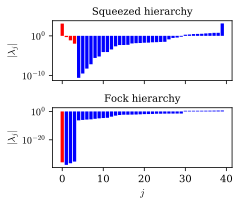

In [33]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(3.5, 3))
bar_plot(np.log(squeezed_sys_to_hier_eigvals[squeezed_sys_to_hier_positive_eigval_idxs]), squeezed_sys_to_hier_positive_eigval_idxs[0], axs[0], bar_kwargs=dict(color='b'))
bar_plot(np.log(np.abs(squeezed_sys_to_hier_eigvals[squeezed_sys_to_hier_negative_eigval_idxs])), squeezed_sys_to_hier_negative_eigval_idxs[0], axs[0], bar_kwargs=dict(color='r'))
bar_plot(np.log(fock_sys_to_hier_eigvals[fock_sys_to_hier_positive_eigval_idxs]), fock_sys_to_hier_positive_eigval_idxs[0], axs[1], bar_kwargs=dict(color='b'))
bar_plot(np.log(np.abs(fock_sys_to_hier_eigvals[fock_sys_to_hier_negative_eigval_idxs])), fock_sys_to_hier_negative_eigval_idxs[0], axs[1], bar_kwargs=dict(color='r'))
axs[0].set_title('Squeezed hierarchy')
axs[0].set_yticks([-10, 0])
axs[0].set_yticklabels(['$10^{-10}$', '$10^0$'])
axs[0].set_ylabel(r'$|\lambda_j|$')
axs[1].set_title('Fock hierarchy')
axs[1].set_yticks([-20, 0])
axs[1].set_yticklabels(['$10^{-20}$', '$10^0$'])
axs[1].set_xlabel('$j$')
axs[1].set_ylabel(r'$|\lambda_j|$')
plt.tight_layout()
plt.savefig('choi-eigvals.pdf', bbox_inches='tight', pad_inches=0.02)

We clearly see the negative eigenvalue for the squeezed